### Necessary imports

In [31]:
#Initial imports
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.base.prediction import PredictionResults

### Exploratory data analysis
 As a first step, we are taking only one stock with security code 1301 for analysis, will try to do initial analysis and predict closing price 

In [32]:
df=pd.read_csv('data/stock_prices/stock_prices.csv')
df.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


In [46]:
# filtering stocks having security code as '1301'
df_kyo = df[df['SecuritiesCode']==1301]

In [47]:
#Preparing the dataset
df_kyo=df_kyo.drop(['RowId','SecuritiesCode','SupervisionFlag','ExpectedDividend','AdjustmentFactor','Volume'],axis=1)
df_kyo['Date']=pd.to_datetime(df_kyo['Date'])
df_kyo.head()

,Date,Open,High,Low,Close,Target
0,2017-01-04,2734.0,2755.0,2730.0,2742.0,0.000730
1865,2017-01-05,2743.0,2747.0,2735.0,2738.0,0.002920
3730,2017-01-06,2734.0,2744.0,2720.0,2740.0,-0.001092
5595,2017-01-10,2745.0,2754.0,2735.0,2748.0,-0.005100
7460,2017-01-11,2748.0,2752.0,2737.0,2745.0,-0.003295


In [48]:
df_kyo=df_kyo.set_index(df_kyo.Date)
df_kyo=df_kyo.drop(['Date'],axis=1)
df_kyo.head()

,Open,High,Low,Close,Target
Date,,,,,
2017-01-04,2734.0,2755.0,2730.0,2742.0,0.000730
2017-01-05,2743.0,2747.0,2735.0,2738.0,0.002920
2017-01-06,2734.0,2744.0,2720.0,2740.0,-0.001092
2017-01-10,2745.0,2754.0,2735.0,2748.0,-0.005100
2017-01-11,2748.0,2752.0,2737.0,2745.0,-0.003295


In [87]:
#Setting daily frequency using forward fill method
df_kyo=df_kyo.asfreq('D',method='ffill')
df_kyo.index

DatetimeIndex(['2017-01-04', '2017-01-05', '2017-01-06', '2017-01-07',
               '2017-01-08', '2017-01-09', '2017-01-10', '2017-01-11',
               '2017-01-12', '2017-01-13',
               ...
               '2021-11-24', '2021-11-25', '2021-11-26', '2021-11-27',
               '2021-11-28', '2021-11-29', '2021-11-30', '2021-12-01',
               '2021-12-02', '2021-12-03'],
              dtype='datetime64[ns]', name='Date', length=1795, freq='D')

### Preparing data before fitting it to ARIMA 
 * checking for stationarity, trends and seasonality in data
 
 ARIMA in python :https://towardsdatascience.com/arima-model-in-python-7bfc7fb792f9

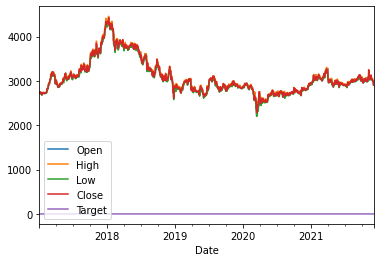

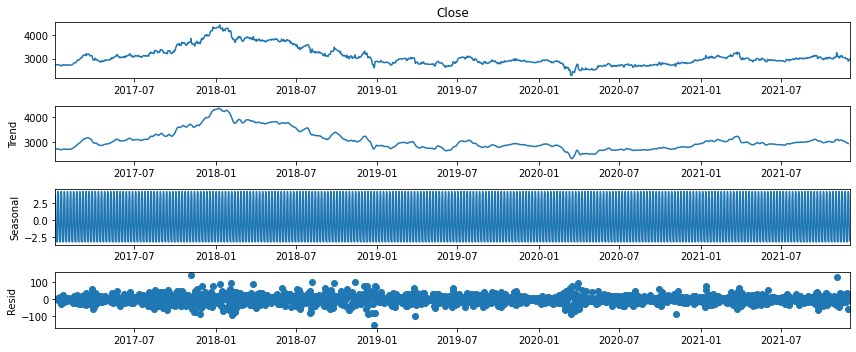

In [88]:
# Additive Decomposition (y = Trend + Seasonal + Residuals)
df_kyo = df_kyo.dropna()
df_kyo.plot()

result_add = seasonal_decompose(df_kyo['Close'], model='ad')

rcParams['figure.figsize'] = 12,5
result_add.plot();

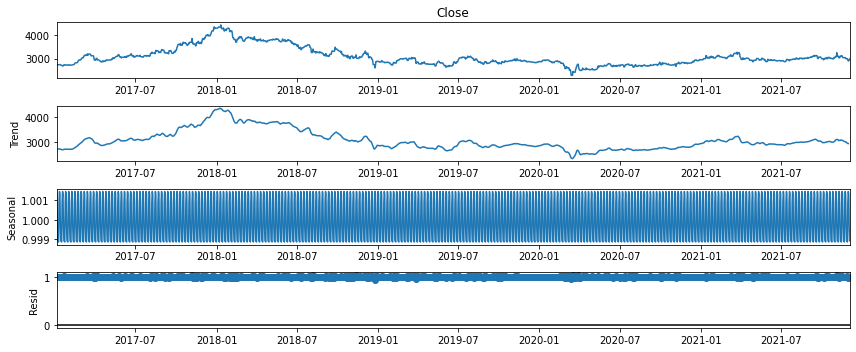

In [89]:
result_mul = seasonal_decompose(df_kyo['Close'], model='multiplicative')

rcParams['figure.figsize'] = 12,5
result_mul.plot();

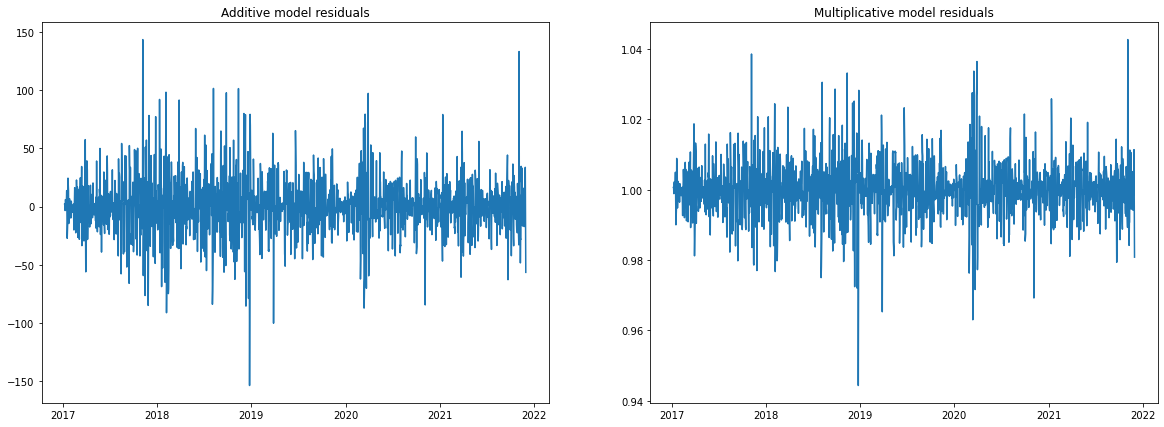

In [90]:
# Plot the residuals with "result_add.resid" to decide
f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,7))
ax1.plot(result_add.resid); ax1.set_title("Additive model residuals")
ax2.plot(result_mul.resid); ax2.set_title("Multiplicative model residuals");

In [92]:
#Checking for stationarity in data with help of Dicky fuller test
from statsmodels.tsa.stattools import adfuller
adfuller(df_kyo.Close)[1]  # p-value

0.3418522608835085

In [93]:
#Testing stationarity with help of Dicky fuller test
result=adfuller(df_kyo['Close'])
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'],result))

{'adf': -1.8793179630352437,
 'pvalue': 0.3418522608835085,
 'usedlag': 0,
 'nobs': 1794,
 'criticalvalues': {'1%': -3.4340003240943844,
  '5%': -2.8631524150111547,
  '10%': -2.567628397867784},
 'icbest': 17357.237849513338}

* As you can see we fail to reject the null hypothesis because we have a p-value>0.05. That suggests that the series is not stationary and we need to use differencing in order to make our time series stationary

<AxesSubplot:xlabel='Date'>

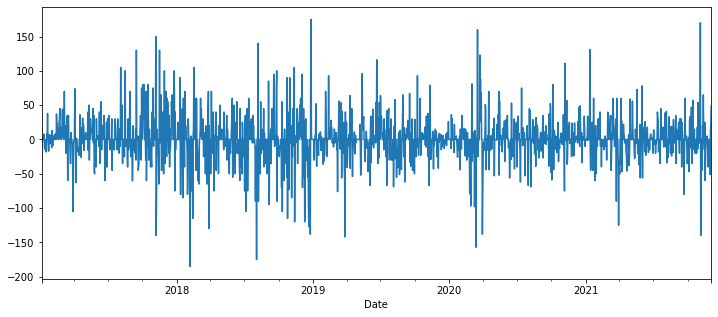

In [94]:
#1st oreder diffrentiation of time series
df_kyo['1D']=df_kyo['Close'].diff(1)
df_kyo['1D'].plot()

* From the above figure, It looks like our time series turned  into stationary time series after first order differentiation
  next step: With help of Dicky fuller test we will again confirm the stationarity of our time series

In [95]:
#note we are dropping na values because the first value of the first difference is NA
result=adfuller(df_kyo['1D'].dropna())
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'],result))

{'adf': -42.47752443853967,
 'pvalue': 0.0,
 'usedlag': 0,
 'nobs': 1793,
 'criticalvalues': {'1%': -3.434002362895342,
  '5%': -2.863153315036348,
  '10%': -2.5676288771043367},
 'icbest': 17351.910015002628}

* The p-value is less than 0.05 so we can reject the null hypothesis. That means the second difference is stationary and that suggests that a good estimate for the value d is 1

Next step: We will be checking seasonality in time series and hence shifting the time series with number of months in an year i.e. 12

<AxesSubplot:xlabel='Date'>

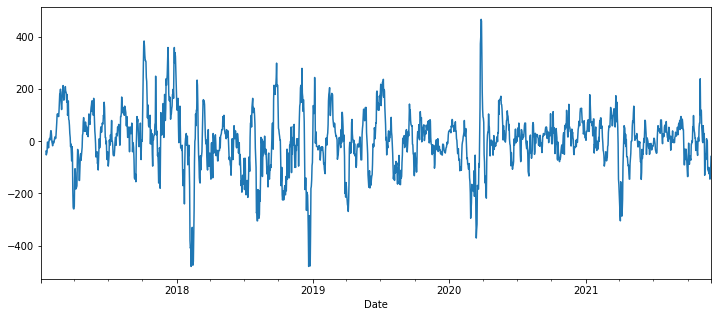

In [96]:
#Seasonal plot of the time series
df_kyo['Seasonal_Difference']=df_kyo['Close']-df_kyo['Close'].shift(12)
df_kyo['Seasonal_Difference'].plot()

In [97]:
result=adfuller((df_kyo['Seasonal_Difference']).dropna())
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'],result))

{'adf': -6.678878625337295,
 'pvalue': 4.393580813120617e-09,
 'usedlag': 25,
 'nobs': 1757,
 'criticalvalues': {'1%': -3.434077307635689,
  '5%': -2.863186398838776,
  '10%': -2.5676464933112495},
 'icbest': 17759.816556230933}

Autocorrelation plots are often used for checking randomness in time series. This is done by computing autocorrelations 
for data values at varying time lags.If time series is random, such autocorrelations should be near zero for any and all 
time-lag separations. If time series is non-random then one or more of the autocorrelations will be significantly non-zero.

/home/prateeksha/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


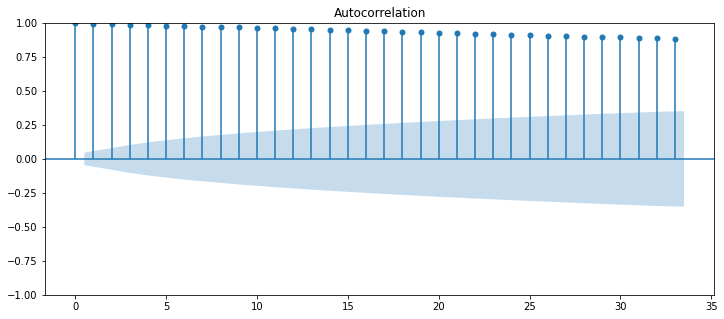

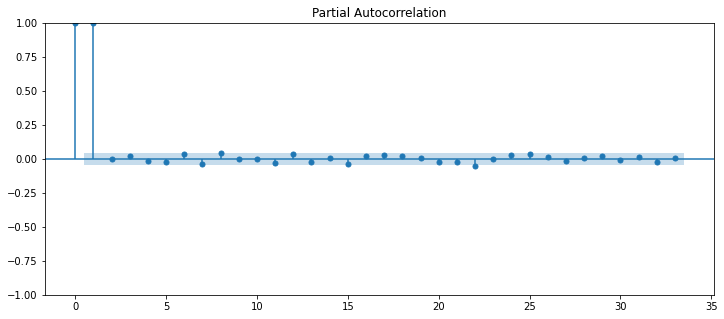

In [98]:
# ACF and PACF plots of timeseries
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig1=plot_acf(df_kyo['Close'].dropna())
fig2=plot_pacf(df_kyo['Close'].dropna())

In [99]:
print('additive resid: ', adfuller(result_add.resid.dropna())[1])
print('multipl resid: ', adfuller(result_mul.resid.dropna())[1])

additive resid:  4.1020256552493763e-26
multipl resid:  2.767753868073482e-29


/home/prateeksha/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


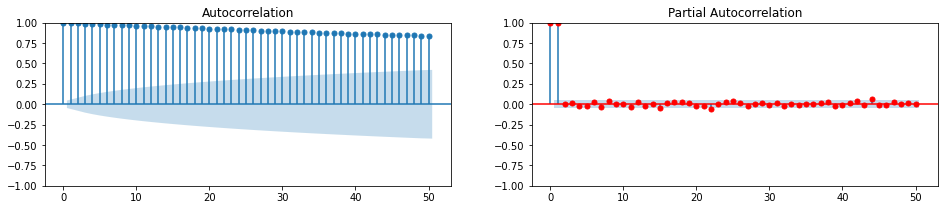

In [100]:
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(df_kyo.Close, lags=50, ax=axes[0]);
plot_pacf(df_kyo.Close, lags=50, ax=axes[1], color='r');

After checking with Augmented Dicky fuller test, we know that this time series is not stationary and to introduce stationarity,
we will try differencing

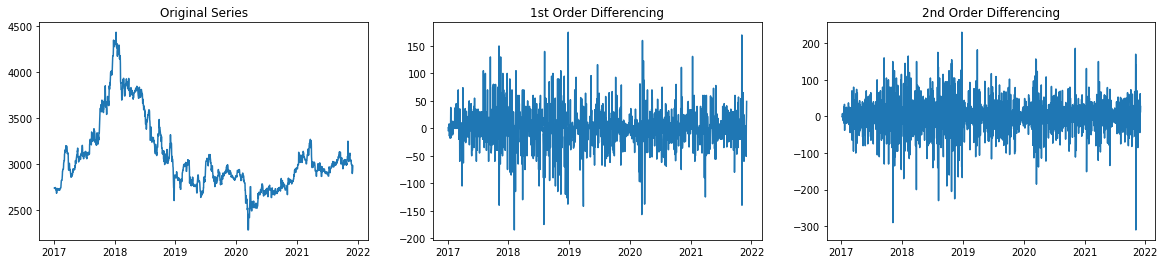

In [112]:
zero_diff = df_kyo.Close
first_order_diff = df_kyo.Close.diff(1)
second_order_diff = df_kyo.Close.diff(1).diff(1)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4))
ax1.plot(zero_diff); ax1.set_title('Original Series')
ax2.plot(first_order_diff); ax2.set_title('1st Order Differencing')
ax3.plot(second_order_diff); ax3.set_title('2nd Order Differencing');

From the above graph we can see that data starts looking stationary after first and second order differencing

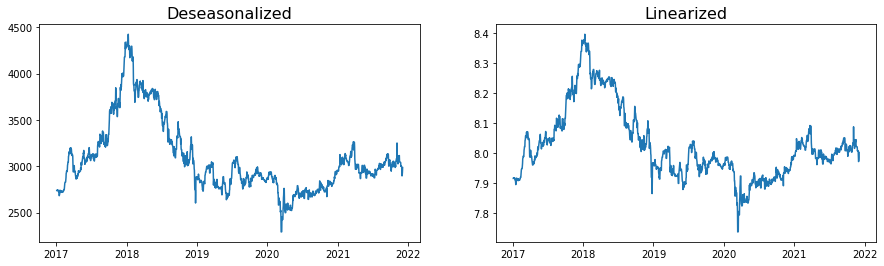

In [114]:
# Let's remove seasons
df_kyo['deseasonalized'] = df_kyo.Close.values/result_mul.seasonal

plt.figure(figsize=(15,4)); plt.subplot(1,2,1); plt.plot(df_kyo.deseasonalized);
plt.title('Deseasonalized', fontsize=16);

# Also remove exponential trend 
df_kyo['linearized'] = np.log(df_kyo['deseasonalized'])

plt.subplot(1,2,2); plt.plot(df_kyo['linearized'])
plt.title('Linearized', fontsize=16);

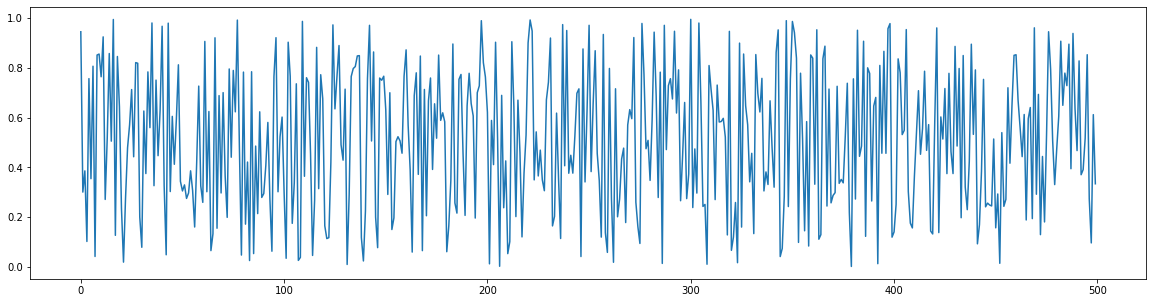

In [105]:
# White noise has no information to extract!
import scipy
plt.figure(figsize=(20,5));
plt.plot(np.arange(500), [scipy.stats.uniform().rvs() for i in np.arange(500)]);

### Forecasting using ARIMA

In [106]:
# Create a correct Training/Test split to predict the last 50 points
train = df_kyo['Close'][0:1200]
test = df_kyo['Close'][1200:]

# Build Model
arima = ARIMA(train, order=(0, 1, 0), trend='t')  
arima = arima.fit()

# Forecast
# Forecast values
forecast = arima.forecast(len(test), alpha=0.05)  # 95% confidence

# Forecast values and confidence intervals
forecast_results = arima.get_forecast(len(test), alpha=0.05)
forecast = forecast_results.predicted_mean
confidence_int = forecast_results.conf_int().values

In [107]:
# We define here a "Plot forecast vs. real", which also shows historical train set

def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

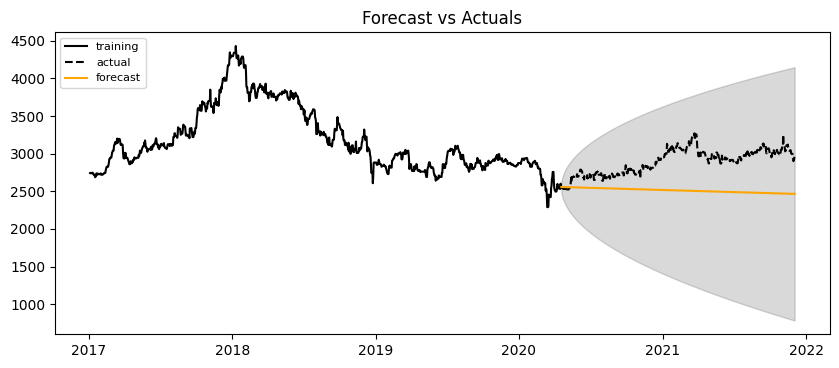

In [108]:
plot_forecast(forecast, train, test, confidence_int[:,0], confidence_int[:,1])

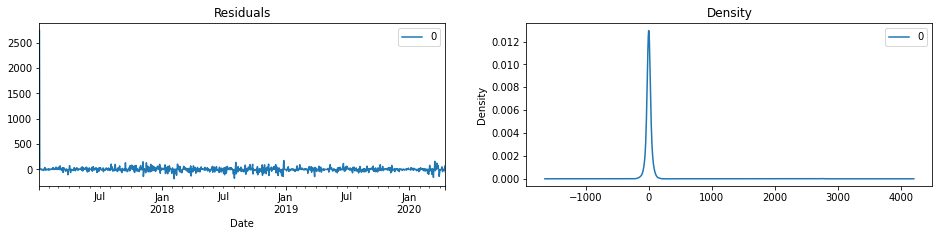

In [109]:
residuals = pd.DataFrame(arima.resid)

fig, ax = plt.subplots(1,2, figsize=(16,3))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1]);

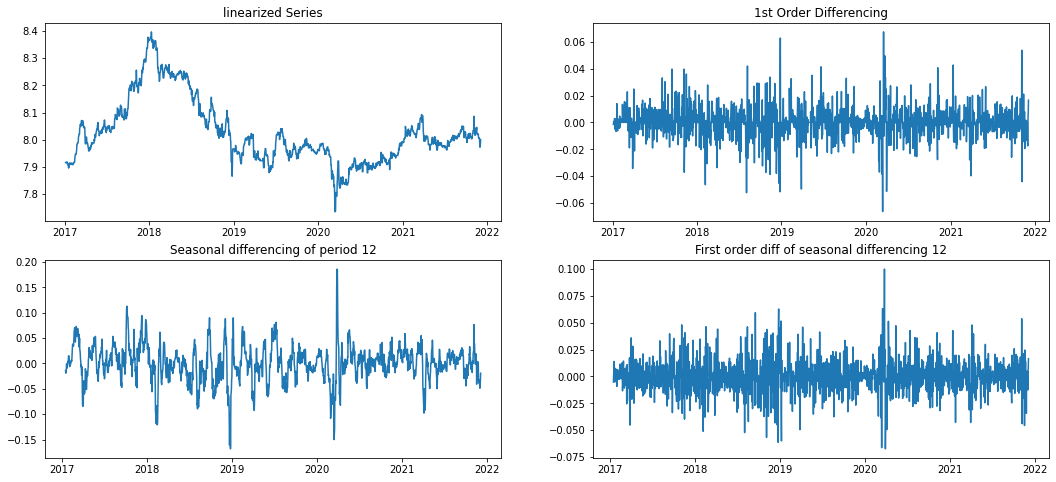

In [110]:
fig, axs = plt.subplots(2, 2, figsize=(18,8))
# keeping just log transform to stay ~ linear
df_kyo['log'] = np.log(df_kyo.Close)

# linearized series
axs[0,0].plot(df_kyo.log); axs[0,0].set_title('linearized Series')

# Normal differencing
axs[0,1].plot(df_kyo.log.diff(1)); axs[0,1].set_title('1st Order Differencing')

# Seasonal differencing
axs[1,0].plot(df_kyo.log.diff(12))
axs[1,0].set_title('Seasonal differencing of period 12')

# Sesonal + Normal differencing
axs[1,1].plot(df_kyo.log.diff(12).diff(1))
axs[1,1].set_title('First order diff of seasonal differencing 12');

### Forecasting using SARIMAX

In [111]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Build Model
sarima = SARIMAX(train, order=(0, 1, 0), seasonal_order=(2, 0, 2, 12))
sarima = sarima.fit(maxiter=75)

# Forecast
results = sarima.get_forecast(len(test), alpha=0.05)
forecast = results.predicted_mean
confidence_int = results.conf_int()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.97569D+00    |proj g|=  1.29432D-02

At iterate    5    f=  4.97559D+00    |proj g|=  4.78821D-03

At iterate   10    f=  4.97494D+00    |proj g|=  1.29676D-02

At iterate   15    f=  4.97481D+00    |proj g|=  1.40065D-03

At iterate   20    f=  4.97456D+00    |proj g|=  2.54425D-03

At iterate   25    f=  4.97452D+00    |proj g|=  2.19128D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     34      1     0     0   

##### To be continued!!